In [1]:
# declare universals
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from scipy.signal import convolve2d

import urllib.request
from io import StringIO

# Get data from the following URLS
MARKERS = 'ov^.psDPx*<>+pDov^.ps'
URL_C='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
URL_D='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
#URL_R='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

In [2]:
# declare data gathering and cleaning function 
def get_data(url, add_total=False):
    response = urllib.request.urlopen(url)
    data = response.read()      # a `bytes` object
    text = data.decode('utf-8') # a `str`; this step can't be used if data is binary

    # Create dataframe
    df = pd.read_csv(StringIO(text), sep=',') # index_col=[0, 1, 2, 3
    
    # Reshape data
    df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Cases')

    # Merge various regions of countries
    df = df.groupby(['Country/Region', 'Date']).sum()
    
    # Pivot table
    df = df.pivot_table(values='Cases', columns='Date', index='Country/Region')

    # Ignore 'Others' which refers to ships mostly
    df = df.loc[df.index != 'Cruise Ship']

    # Print some data to the console
    # print(df.nlargest(10, df.columns[-1]))

    # Transpose rows/columns so that rows correspond to days
    df = df.reset_index()
    df = df.melt(id_vars=['Country/Region'], value_name='Cases')
    df = df.pivot_table(values='Cases', columns='Country/Region', index='Date')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Start date is 1st February 2020
    #df = df.loc[df.index >= '2020-02-01']
    df = df.loc[df.index >= '2020-02-20']
    
    # Add a total by summing all countries
    if add_total:
        df['World'] = df.sum(axis=1)

    return df

In [3]:
# declare plotting function
def plot_data(df, title='', min=None, max=None, ylog=False, stack=False, subplot=111, fig=None, yticks=None, gf=False, timebase = 28):
    
    # Create new fig
    if fig is None:
        fig = plt.figure()
        
    # Add to existing fig 
    ax = fig.add_subplot(subplot)
    
    # Create x and y data for plotting 
    x = df.index.to_numpy()
    x_t = df.index.to_numpy(dtype='float64')
    y = df.to_numpy()
    
    # If the user wants a graph of Growth Rate, do some spooky mathemagic....
    # This part needs better commenting!
    if gf:
        x = x[2:]
        y = y[2:]
        x_t = x_t[2:]
        y = np.diff(y, axis=0)
        y = np.insert(y, 0, y[0],axis=0)
        y = np.insert(y, -1, y[-1], axis=0)
        y = convolve2d(y, [[0.25], [0.5], [0.25]], mode='valid')
        y = np.diff(np.log(y + 1e-3), axis=0)
        y = np.insert(y, 0, y[0],axis=0)
        y = np.insert(y, -1, y[-1], axis=0)
        y = convolve2d(y, [[0.25], [0.5], [0.25]], mode='valid')
        x = x[2:]
        x_t = x_t[2:]
        #print(x.shape, y.shape)
        
    if stack:
        ax.stackplot(x, y.transpose(), labels=df.columns)
    else:
        # Mark data point every 7 days
        ax.plot(x, y, markevery=7)

    # Set axes, grid and ticks
    if min is not None and max is not None:
        ax.set_ylim([min, max])
    if ylog:
        ax.set_yscale('log')
        locmin = plticker.LogLocator(base=10.0, subs=(1,10 ))
        ax.yaxis.set_major_formatter(plticker.FormatStrFormatter("%.0f"))
        ax.yaxis.set_major_locator(locmin)

    ax.grid(axis='y', which='major', linewidth=0.8)
    ax.grid(axis='y', which='minor', linewidth=0.3)
    ax.grid(axis='x', which='both')    
    
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=timebase))
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=timebase/2))

    if stack:
        ax.legend(loc='upper left')
    else:
        for i, line in enumerate(ax.get_lines()):
            line.set_marker(MARKERS[i])
            #line.get_color()
            if gf:
                # calc the trendline
                z = np.polyfit(x_t[4:], y[4:, i], 1)
                p = np.poly1d(z)
                ax.plot(x, p(x_t), "--", color=line.get_color())
        
        ax.legend(ax.get_lines(), df.columns, loc='upper left')
    
    # Set graph title
    ax.set_title(title)
    
    ax.yaxis.tick_right()
    
    return ax

In [4]:
# Import data, and create difference data
df1 = get_data(URL_C, add_total=True) # cases
df2 = df1.diff() # daily cases
df3 = get_data(URL_D, add_total=True) # deaths
df4 = df3.diff() # daily deaths

In [ ]:
# save data from this session
df1.to_csv('conf.csv')
df2.to_csv('conf_new.csv')
df3.to_csv('dead.csv')
df4.to_csv('dead_new.csv')

In [ ]:
# if your internet connection is down, use this to read saved data from the last session
df1 = pd.read_csv('conf.csv',index_col='Date')
df2 = pd.read_csv('conf_new.csv',index_col='Date')
df3 = pd.read_csv('dead.csv',index_col='Date')
df4 = pd.read_csv('dead_new.csv',index_col='Date')
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)
df3.index = pd.to_datetime(df3.index)
df4.index = pd.to_datetime(df4.index)

In [5]:
# create some filters for different country groups
countries1 = ['United Kingdom','Ireland', 'France', 'Italy', 'Spain', 'US', 'World']
countries2 = ['Germany','Austria', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Russia']
countries3 = ['Japan','Korea, South','China']

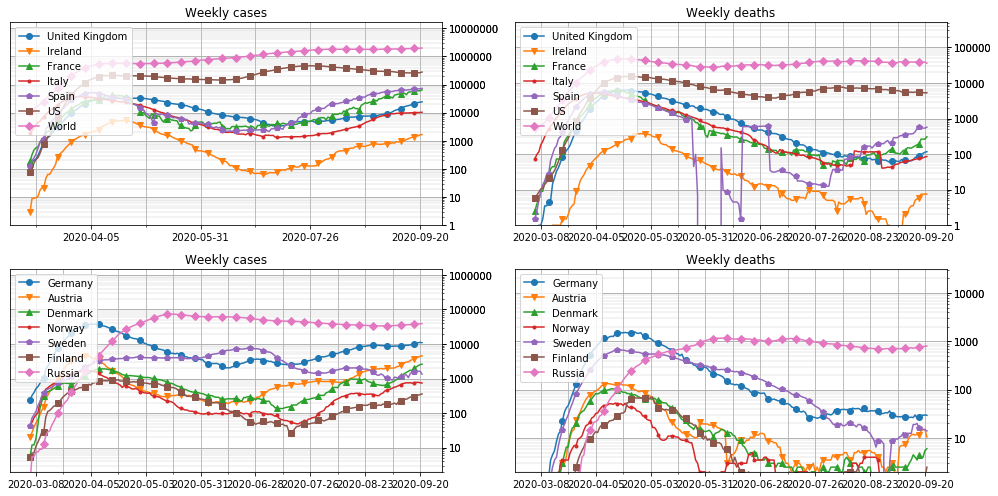

In [19]:
# 2x2 plot for weekly cases and deaths for first two country groups
fig = plt.figure(figsize=(14, 7))

plot_data(df2.filter(countries1).rolling(14).sum() / 2, timebase = 56, min=1, max=df2['World'].max()*50, ylog=True, stack=False, title='Weekly cases', fig=fig, subplot=221)
plot_data(df4.filter(countries1).rolling(14).sum() / 2, timebase = 56, min=1, max=df4['World'].max()*50, ylog=True, stack=False, title='Weekly deaths', fig=fig, subplot=222)
plot_data(df2.filter(countries2).rolling(14).sum() / 2, timebase = 56, min=2, max=df2.filter(countries2).rolling(14).sum().max().max()*10, ylog=True, stack=False, title='Weekly cases', fig=fig, subplot=223)
plot_data(df4.filter(countries2).rolling(14).sum() / 2, timebase = 56, min=2, max=df4.filter(countries2).rolling(14).sum().max().max()*10, ylog=True, stack=False, title='Weekly deaths', fig=fig, subplot=224)

fig.set_tight_layout(True)

plt.subplots_adjust(left=0.10, bottom=0.05, right=0.95, top=0.95)
plt.show()

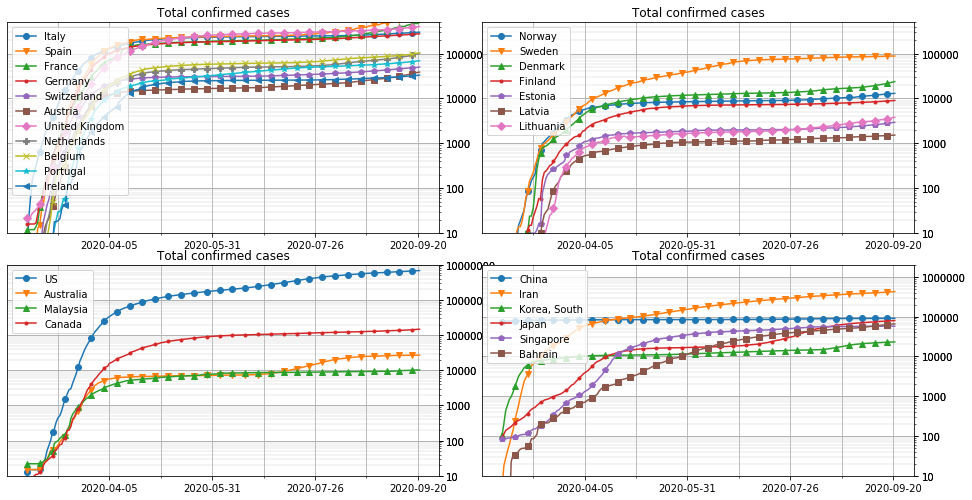

In [21]:
# 2x2 plot grid of raw daily cases for a few countries
fig = plt.figure(figsize=(14,7))

plot_data(df1.filter(['Italy', 'Spain', 'France', 'Germany', 'Switzerland', 'Austria', 'United Kingdom', 'Netherlands', 'Belgium', 'Portugal', 'Ireland']), timebase = 56, min=10, max=500000, ylog=True, title='Total confirmed cases', fig=fig, subplot=221)
plot_data(df1.filter(['Norway', 'Sweden', 'Denmark', 'Finland', 'Estonia', 'Latvia', 'Lithuania']),timebase = 56, min=10, max=500000, ylog=True, title='Total confirmed cases', fig=fig, subplot=222)
plot_data(df1.filter(['US', 'Australia', 'Malaysia', 'Canada']), timebase = 56, min=10, max=10000000, ylog=True, title='Total confirmed cases', fig=fig, subplot=223)
plot_data(df1.filter(['China', 'Iran', 'Korea, South', 'Japan', 'Singapore', 'Bahrain']), timebase = 56, min=10, max=2000000, ylog=True, title='Total confirmed cases', fig=fig, subplot=224)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.10, hspace=0.15)

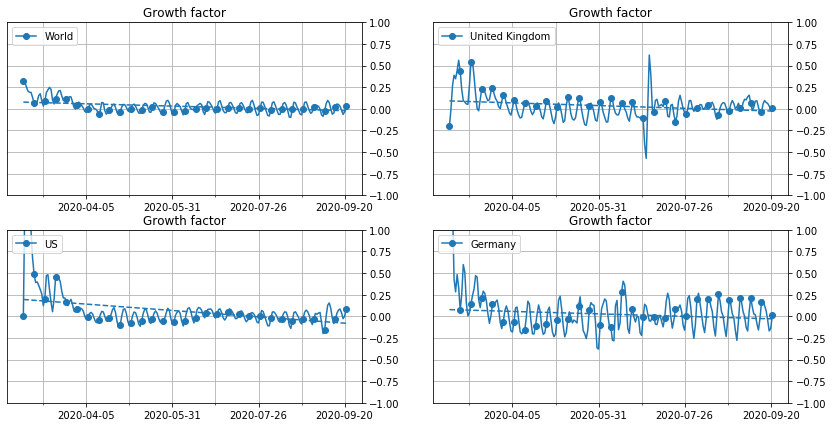

In [32]:
# (experimental) plot growth rates for the world and a few selected countries
fig = plt.figure(figsize=(14,7))
plot_data(df1.filter(['World']), min=-1, max=1, title='Growth factor', gf=True, fig=fig, timebase = 56, subplot=221)
plot_data(df1.filter(['United Kingdom']), min=-1, max=1, title='Growth factor', gf=True, fig=fig, timebase = 56, subplot=222)
plot_data(df1.filter(['US']), min=-1, max=1, title='Growth factor', gf=True, fig=fig, timebase = 56, subplot=223)
plot_data(df1.filter(['Germany']), min=-1, max=1, title='Growth factor', gf=True, fig=fig, timebase = 56, subplot=224)
plt.show()

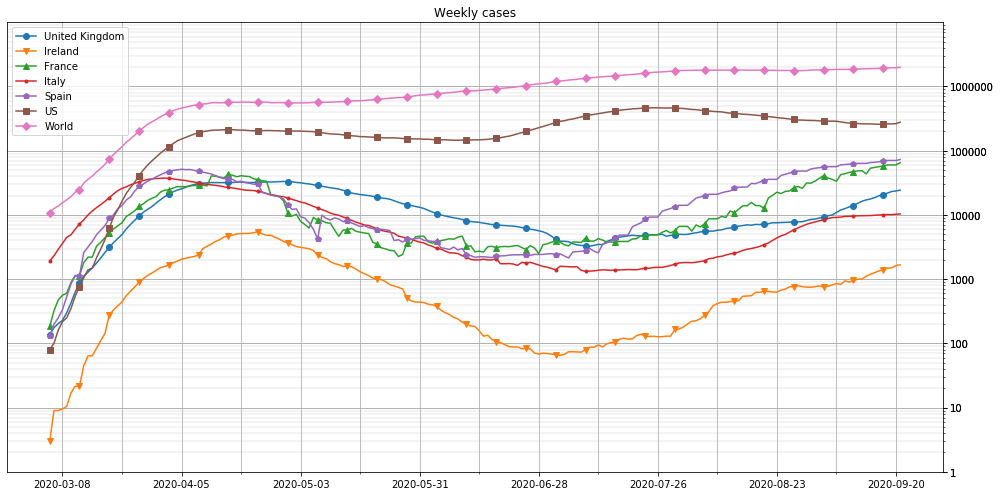

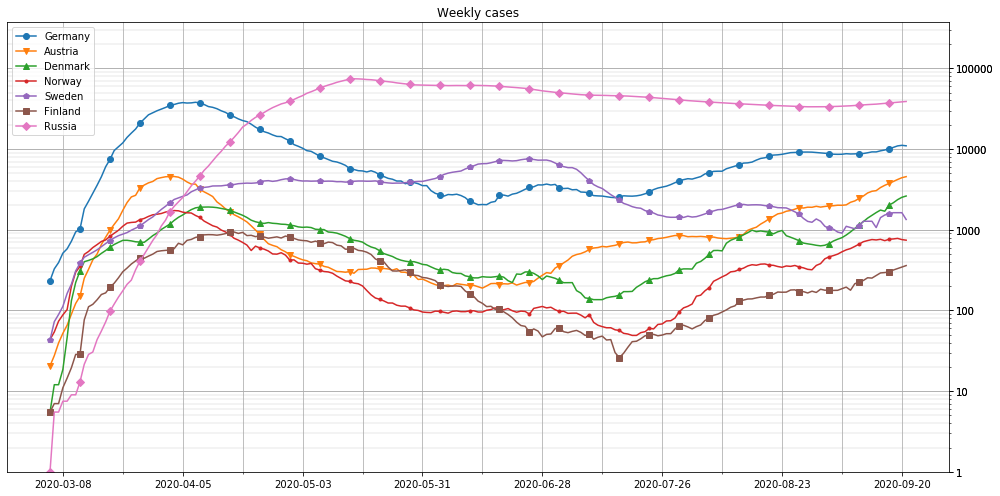

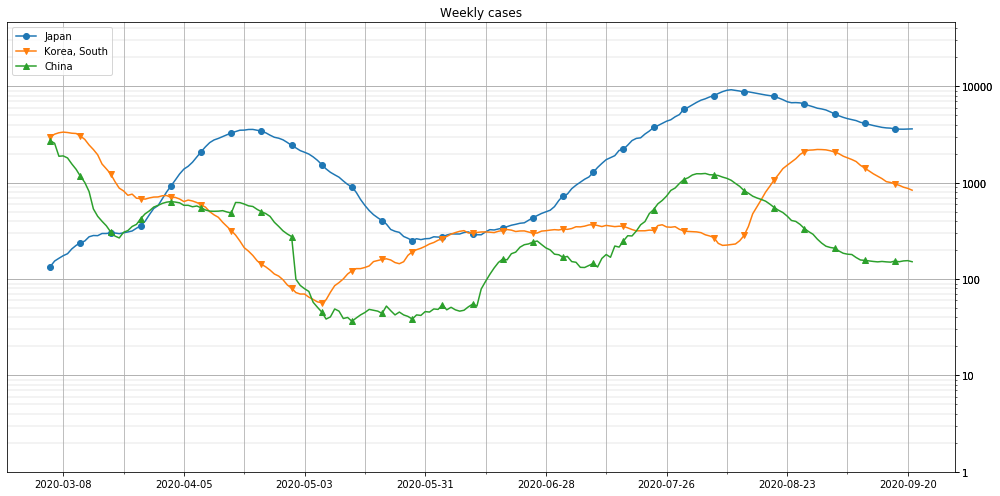

In [31]:
# produce 3 plots of weekly cases for 3 country groups    

fig = plt.figure(figsize=(14, 7))
filter1 = df2.filter(countries1).rolling(14).sum() / 2
plot_data(filter1, min=1, max=filter1.max().max()*5, ylog=True, stack=False, title='Weekly cases', fig=fig)
fig.set_tight_layout(True)

fig = plt.figure(figsize=(14, 7))
filter2 = df2.filter(countries2).rolling(14).sum() / 2
plot_data(filter2, min=1, max=filter2.max().max()*5, ylog=True, stack=False, title='Weekly cases', fig=fig)
fig.set_tight_layout(True)

fig = plt.figure(figsize=(14, 7))
filter3 = df2.filter(countries3).rolling(14).sum() / 2
plot_data(filter3, min=1, max=filter3.max().max()*5, ylog=True, stack=False, title='Weekly cases', fig=fig)
fig.set_tight_layout(True) 

In [49]:
dfUK = df2.filter(['United Kingdom'])
dfUK['Deaths'] = df4['United Kingdom']
dfUK.rename(columns = {'United Kingdom':'Cases'}, inplace = True)

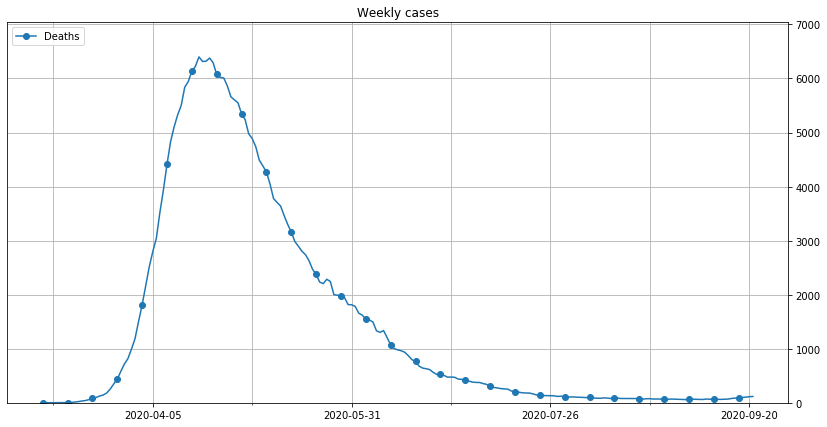

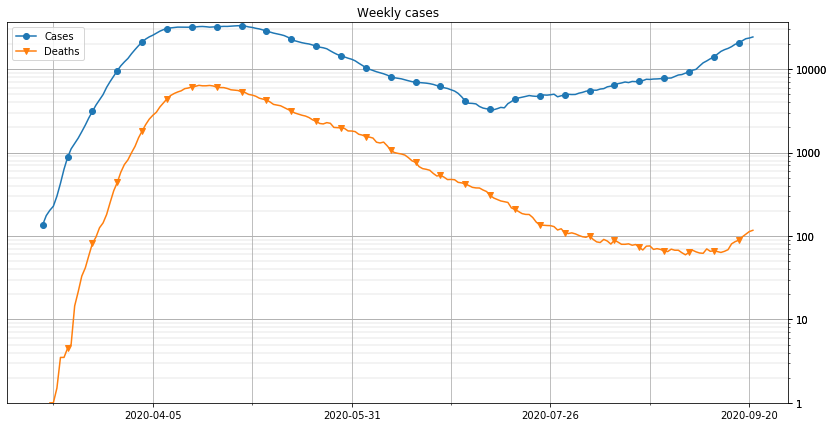

In [61]:
fig = plt.figure(figsize=(14,7))
plot_data(dfUK.filter(['Deaths']).rolling(14).sum() / 2, timebase = 56, min=0, max=dfUK['Deaths'].rolling(14).sum().max()/2*1.1, ylog=False, stack=False, title='Weekly cases', fig=fig)
fig = plt.figure(figsize=(14,7))
plot_data(dfUK.rolling(14).sum() / 2, timebase = 56, min=1, max=dfUK['Cases'].rolling(14).sum().max()/2*1.1, ylog=True, stack=False, title='Weekly cases', fig=fig)

In [17]:
df2['United Kingdom'].rolling(14).sum().max()/2,

(33171.0,)